In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
# 1. 이미지 경로 및 레이블 리스트 생성
base_dir_original = 'Training'  # 데이터가 저장된 기본 경로
image_paths = []
labels = []

for folder_name in os.listdir(base_dir_original):
    folder_path = os.path.join(base_dir_original, folder_name)
    if os.path.isdir(folder_path):
        # 레이블 추출: 폴더 이름에서 정보 파싱
        label = folder_name.split(']')[-1].split('_')[0]
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(label)
unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

# train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42
)

# 3. 이미지 로드 및 전처리 함수 정의
def preprocess_image(image_path, label, target_height=128, target_width=128):
    # 이미지 읽기
    image = tf.io.read_file(image_path)
    # 이미지 디코딩 및 리사이징
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    # 픽셀 값을 0~1로 정규화
    image = image / 255.0
    return image, label

# 4. TensorFlow 데이터 파이프라인 생성
def create_dataset(image_paths, labels, batch_size=32, target_height=128, target_width=128):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    # 데이터셋 전처리 매핑
    dataset = dataset.map(lambda path, label: preprocess_image(path, label, target_height, target_width),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # 데이터 셔플 및 배치
    dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# 5. 학습 및 테스트 데이터셋 생성
batch_size = 32
train_dataset = create_dataset(train_paths, train_labels, batch_size)
test_dataset = create_dataset(test_paths, test_labels, batch_size)

2024-12-09 03:26:03.578430: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 03:26:03.787172: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-12-09 03:26:05.734377: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 03:26:05.947224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46382 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:65:00.0, compute capability: 8.0


In [2]:
import tensorflow as tf

model13 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    
    # 첫 번째 Convolutional Layer + Batch Normalization
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # 두 번째 Convolutional Layer + Batch Normalization
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # 세 번째 Convolutional Layer + Batch Normalization
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # 네 번째 Convolutional Layer + Batch Normalization
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),

    # 첫 번째 Fully Connected Layer + Batch Normalization
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(7, activation='softmax')
])


In [3]:
model13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [5]:
# 모델 컴파일
model13.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])





In [6]:
result13 =model13.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50


2024-12-09 03:27:18.753031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-09 03:27:28.911337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2812 of 10508
2024-12-09 03:27:38.913535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5683 of 10508
2024-12-09 03:27:48.909802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8500 of 10508
2024-12-09 03:27:55.806238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2024-12-09 03:27:56.146069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2024-12-09 03:27:56.677644: I tensorflow/compiler/xla

329/329 [==============================] - ETA: 0s - loss: 3.5404 - accuracy: 0.3273

2024-12-09 03:28:14.215515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 03:28:19.927158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 63s 66ms/step - loss: 3.5404 - accuracy: 0.3273 - val_loss: 3.4958 - val_accuracy: 0.1867
Epoch 2/50


2024-12-09 03:28:30.413491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2911 of 10508
2024-12-09 03:28:40.421965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5775 of 10508
2024-12-09 03:28:50.411990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8554 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 2.4002 - accuracy: 0.3701 

2024-12-09 03:28:57.132367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 2.2371 - accuracy: 0.4057

2024-12-09 03:29:11.468515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2900 of 4504
2024-12-09 03:29:17.157248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 62ms/step - loss: 2.2371 - accuracy: 0.4057 - val_loss: 2.2133 - val_accuracy: 0.3581
Epoch 3/50


2024-12-09 03:29:27.633775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2885 of 10508
2024-12-09 03:29:37.642576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5775 of 10508
2024-12-09 03:29:47.635103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8604 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 2.0621 - accuracy: 0.4703 

2024-12-09 03:29:54.138114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.9879 - accuracy: 0.4675

2024-12-09 03:30:08.812195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2856 of 4504
2024-12-09 03:30:14.534392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 64ms/step - loss: 1.9879 - accuracy: 0.4675 - val_loss: 1.9571 - val_accuracy: 0.4893
Epoch 4/50


2024-12-09 03:30:25.048992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2842 of 10508
2024-12-09 03:30:35.048786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5699 of 10508
2024-12-09 03:30:45.049632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8524 of 10508


 21/329 [>.............................] - ETA: 2s - loss: 2.0393 - accuracy: 0.4985 

2024-12-09 03:30:51.817776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.9808 - accuracy: 0.4956

2024-12-09 03:31:06.427673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 4504
2024-12-09 03:31:11.990689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 63ms/step - loss: 1.9808 - accuracy: 0.4956 - val_loss: 1.9865 - val_accuracy: 0.4660
Epoch 5/50


2024-12-09 03:31:22.501289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2839 of 10508
2024-12-09 03:31:32.494874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5684 of 10508
2024-12-09 03:31:42.493323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8489 of 10508


 17/329 [>.............................] - ETA: 2s - loss: 1.9993 - accuracy: 0.4908 

2024-12-09 03:31:49.322729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.9794 - accuracy: 0.5165

2024-12-09 03:32:04.312394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2884 of 4504
2024-12-09 03:32:09.912509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 1.9793 - accuracy: 0.5167 - val_loss: 2.3035 - val_accuracy: 0.3961
Epoch 6/50


2024-12-09 03:32:20.383955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2888 of 10508
2024-12-09 03:32:30.383568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5768 of 10508
2024-12-09 03:32:40.387600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8589 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.9395 - accuracy: 0.5199 

2024-12-09 03:32:46.989323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 2.0601 - accuracy: 0.5345

2024-12-09 03:33:00.488490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2905 of 4504
2024-12-09 03:33:06.072049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 2.0601 - accuracy: 0.5345 - val_loss: 2.3752 - val_accuracy: 0.4520
Epoch 7/50


2024-12-09 03:33:16.543779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2917 of 10508
2024-12-09 03:33:26.548794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5782 of 10508
2024-12-09 03:33:36.546442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8604 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 2.0819 - accuracy: 0.5484 

2024-12-09 03:33:43.085112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 2.1284 - accuracy: 0.5468

2024-12-09 03:33:57.758560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2893 of 4504
2024-12-09 03:34:03.355255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 63ms/step - loss: 2.1282 - accuracy: 0.5469 - val_loss: 2.3935 - val_accuracy: 0.4298
Epoch 8/50


2024-12-09 03:34:13.818482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2881 of 10508
2024-12-09 03:34:23.815776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5729 of 10508
2024-12-09 03:34:33.816772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8562 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.9543 - accuracy: 0.6234 

2024-12-09 03:34:40.451767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.1462 - accuracy: 0.5654

2024-12-09 03:34:54.230575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2905 of 4504
2024-12-09 03:34:59.806223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 2.1469 - accuracy: 0.5650 - val_loss: 2.2617 - val_accuracy: 0.5258
Epoch 9/50


2024-12-09 03:35:10.297718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2881 of 10508
2024-12-09 03:35:20.296363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5761 of 10508
2024-12-09 03:35:30.297452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8586 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 2.0989 - accuracy: 0.5938 

2024-12-09 03:35:36.789522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 2.1707 - accuracy: 0.5799

2024-12-09 03:35:51.891616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 03:35:57.443731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 65ms/step - loss: 2.1712 - accuracy: 0.5798 - val_loss: 2.6513 - val_accuracy: 0.4507
Epoch 10/50


2024-12-09 03:36:08.013959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2926 of 10508
2024-12-09 03:36:18.014327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5788 of 10508
2024-12-09 03:36:28.015515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8624 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 2.0873 - accuracy: 0.6156 

2024-12-09 03:36:34.405717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 2.1901 - accuracy: 0.5967

2024-12-09 03:36:49.383343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2896 of 4504
2024-12-09 03:36:54.941607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 64ms/step - loss: 2.1901 - accuracy: 0.5967 - val_loss: 2.0680 - val_accuracy: 0.6075
Epoch 11/50


2024-12-09 03:37:05.423107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 10508
2024-12-09 03:37:15.418757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5775 of 10508
2024-12-09 03:37:25.420664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8602 of 10508


 18/329 [>.............................] - ETA: 3s - loss: 2.0859 - accuracy: 0.5972 

2024-12-09 03:37:31.942138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 2.1353 - accuracy: 0.6112

2024-12-09 03:37:45.820963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2878 of 4504
2024-12-09 03:37:51.489740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 2.1353 - accuracy: 0.6112 - val_loss: 2.2732 - val_accuracy: 0.5522
Epoch 12/50


2024-12-09 03:38:02.026974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2875 of 10508
2024-12-09 03:38:12.025769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5769 of 10508
2024-12-09 03:38:22.031124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8592 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 2.0915 - accuracy: 0.6687 

2024-12-09 03:38:28.550507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 2.1969 - accuracy: 0.6152

2024-12-09 03:38:43.744206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 03:38:49.301152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 65ms/step - loss: 2.1973 - accuracy: 0.6153 - val_loss: 2.6127 - val_accuracy: 0.5089
Epoch 13/50


2024-12-09 03:38:59.780908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 10508
2024-12-09 03:39:09.780546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-09 03:39:19.773867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8573 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 2.1886 - accuracy: 0.6283 

2024-12-09 03:39:26.492846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.1861 - accuracy: 0.6345

2024-12-09 03:39:40.140678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2878 of 4504
2024-12-09 03:39:45.824318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 60ms/step - loss: 2.1858 - accuracy: 0.6339 - val_loss: 2.5639 - val_accuracy: 0.5420
Epoch 14/50


2024-12-09 03:39:56.340741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-09 03:40:06.344910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5755 of 10508
2024-12-09 03:40:16.341942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8579 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 2.0530 - accuracy: 0.7007 

2024-12-09 03:40:22.906805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 2.1258 - accuracy: 0.6535

2024-12-09 03:40:37.723849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2869 of 4504
2024-12-09 03:40:43.393162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 2.1258 - accuracy: 0.6535 - val_loss: 2.2926 - val_accuracy: 0.6044
Epoch 15/50


2024-12-09 03:40:53.870987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 10508
2024-12-09 03:41:03.877454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5761 of 10508
2024-12-09 03:41:13.869706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8593 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 2.0333 - accuracy: 0.7045 

2024-12-09 03:41:20.406020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 2.1847 - accuracy: 0.6554

2024-12-09 03:41:34.850745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2896 of 4504
2024-12-09 03:41:40.464301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 63ms/step - loss: 2.1851 - accuracy: 0.6554 - val_loss: 2.9939 - val_accuracy: 0.4787
Epoch 16/50


2024-12-09 03:42:15.784954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 10508
2024-12-09 03:42:25.787171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5772 of 10508
2024-12-09 03:42:35.786147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8606 of 10508


 18/329 [>.............................] - ETA: 3s - loss: 2.1189 - accuracy: 0.7031 

2024-12-09 03:42:42.428642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.1258 - accuracy: 0.6594

2024-12-09 03:42:56.538315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2894 of 4504
2024-12-09 03:43:02.223825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 62ms/step - loss: 2.1259 - accuracy: 0.6593 - val_loss: 2.2607 - val_accuracy: 0.5897
Epoch 17/50


2024-12-09 03:43:12.807085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2907 of 10508
2024-12-09 03:43:22.804938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5787 of 10508
2024-12-09 03:43:32.805456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8624 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.9511 - accuracy: 0.7188 

2024-12-09 03:43:39.254788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 2.0965 - accuracy: 0.6727

2024-12-09 03:43:54.117093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2890 of 4504
2024-12-09 03:43:59.829921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 2.0963 - accuracy: 0.6727 - val_loss: 2.7095 - val_accuracy: 0.4860
Epoch 18/50


2024-12-09 03:44:10.420958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2910 of 10508
2024-12-09 03:44:20.422084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5770 of 10508
2024-12-09 03:44:30.421672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8578 of 10508


 18/329 [>.............................] - ETA: 2s - loss: 1.9711 - accuracy: 0.7465 

2024-12-09 03:44:37.066547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 2.0848 - accuracy: 0.6808

2024-12-09 03:44:52.121763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 4504
2024-12-09 03:44:57.763005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 65ms/step - loss: 2.0860 - accuracy: 0.6802 - val_loss: 2.1986 - val_accuracy: 0.6234
Epoch 19/50


2024-12-09 03:45:08.281437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2903 of 10508
2024-12-09 03:45:18.282426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5785 of 10508
2024-12-09 03:45:28.288883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8619 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.9202 - accuracy: 0.7172 

2024-12-09 03:45:34.720105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.0872 - accuracy: 0.6877

2024-12-09 03:45:49.773502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2855 of 4504
2024-12-09 03:45:55.553386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 65ms/step - loss: 2.0875 - accuracy: 0.6878 - val_loss: 2.3609 - val_accuracy: 0.6183
Epoch 20/50


2024-12-09 03:46:06.052936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2877 of 10508
2024-12-09 03:46:16.055157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5724 of 10508
2024-12-09 03:46:26.052303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8502 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 2.0721 - accuracy: 0.7072 

2024-12-09 03:46:32.851360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.0754 - accuracy: 0.6972

2024-12-09 03:46:47.940287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2893 of 4504
2024-12-09 03:46:53.549639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 2.0765 - accuracy: 0.6967 - val_loss: 2.6024 - val_accuracy: 0.5484
Epoch 21/50


2024-12-09 03:47:27.971162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2878 of 10508
2024-12-09 03:47:37.967339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5745 of 10508
2024-12-09 03:47:47.968318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8577 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.9129 - accuracy: 0.7406 

2024-12-09 03:47:54.547094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 2.0401 - accuracy: 0.7084

2024-12-09 03:48:09.711991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2911 of 4504
2024-12-09 03:48:15.280713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 65ms/step - loss: 2.0401 - accuracy: 0.7084 - val_loss: 2.6830 - val_accuracy: 0.5022
Epoch 22/50


2024-12-09 03:48:49.887664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2894 of 10508
2024-12-09 03:48:59.887176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5739 of 10508
2024-12-09 03:49:09.892566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8574 of 10508


 18/329 [>.............................] - ETA: 2s - loss: 2.0260 - accuracy: 0.7274 

2024-12-09 03:49:16.469323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.0633 - accuracy: 0.7158

2024-12-09 03:49:31.486898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 4504
2024-12-09 03:49:37.064387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 2.0624 - accuracy: 0.7163 - val_loss: 2.5311 - val_accuracy: 0.5750
Epoch 23/50


2024-12-09 03:49:47.567015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2904 of 10508
2024-12-09 03:49:57.569809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5769 of 10508
2024-12-09 03:50:07.567808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8576 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.9278 - accuracy: 0.7763 

2024-12-09 03:50:14.140550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 2.0333 - accuracy: 0.7271

2024-12-09 03:50:29.377816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2902 of 4504
2024-12-09 03:50:35.260203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 66ms/step - loss: 2.0356 - accuracy: 0.7264 - val_loss: 2.5499 - val_accuracy: 0.5777
Epoch 24/50


2024-12-09 03:50:45.733919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2839 of 10508
2024-12-09 03:50:55.730614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5745 of 10508
2024-12-09 03:51:05.732869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8562 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.9592 - accuracy: 0.7312 

2024-12-09 03:51:12.301657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 2.0043 - accuracy: 0.7292

2024-12-09 03:51:27.008662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2905 of 4504
2024-12-09 03:51:32.564716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 63ms/step - loss: 2.0045 - accuracy: 0.7291 - val_loss: 2.3193 - val_accuracy: 0.5873
Epoch 25/50


2024-12-09 03:51:43.124637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2913 of 10508
2024-12-09 03:51:53.128306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5818 of 10508
2024-12-09 03:52:03.130680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8662 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.8330 - accuracy: 0.7845 

2024-12-09 03:52:09.367945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 2.0116 - accuracy: 0.7360

2024-12-09 03:52:24.421975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2922 of 4504
2024-12-09 03:52:29.931275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 64ms/step - loss: 2.0134 - accuracy: 0.7358 - val_loss: 2.3266 - val_accuracy: 0.6421
Epoch 26/50


2024-12-09 03:52:40.425165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2906 of 10508
2024-12-09 03:52:50.428735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5813 of 10508
2024-12-09 03:53:00.430984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8609 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.9040 - accuracy: 0.7750 

2024-12-09 03:53:06.849080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.0180 - accuracy: 0.7327

2024-12-09 03:53:21.573020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 03:53:27.122847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 63ms/step - loss: 2.0181 - accuracy: 0.7331 - val_loss: 2.4322 - val_accuracy: 0.6141
Epoch 27/50


2024-12-09 03:53:37.629451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2904 of 10508
2024-12-09 03:53:47.629688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5802 of 10508
2024-12-09 03:53:57.631170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8637 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.9157 - accuracy: 0.7859 

2024-12-09 03:54:03.970237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.9856 - accuracy: 0.7444

2024-12-09 03:54:19.054078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2910 of 4504
2024-12-09 03:54:24.590775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 64ms/step - loss: 1.9872 - accuracy: 0.7440 - val_loss: 3.1262 - val_accuracy: 0.4221
Epoch 28/50


2024-12-09 03:54:35.063090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-09 03:54:45.067924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5755 of 10508
2024-12-09 03:54:55.065532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8571 of 10508


 18/329 [>.............................] - ETA: 2s - loss: 1.9832 - accuracy: 0.7639 

2024-12-09 03:55:01.701029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 2.0128 - accuracy: 0.7453

2024-12-09 03:55:16.384669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2874 of 4504
2024-12-09 03:55:22.097985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 2.0128 - accuracy: 0.7453 - val_loss: 2.6493 - val_accuracy: 0.5881
Epoch 29/50


2024-12-09 03:55:32.602004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2916 of 10508
2024-12-09 03:55:42.605101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5797 of 10508
2024-12-09 03:55:52.609809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8640 of 10508


 21/329 [>.............................] - ETA: 2s - loss: 1.9119 - accuracy: 0.7827 

2024-12-09 03:55:58.961028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.9871 - accuracy: 0.7554

2024-12-09 03:56:14.025780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 03:56:19.619640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 1.9875 - accuracy: 0.7553 - val_loss: 2.3896 - val_accuracy: 0.6405
Epoch 30/50


2024-12-09 03:56:30.142641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2913 of 10508
2024-12-09 03:56:40.142680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5797 of 10508
2024-12-09 03:56:50.141689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8640 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.9476 - accuracy: 0.7796 

2024-12-09 03:56:56.498521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.9618 - accuracy: 0.7664

2024-12-09 03:57:11.401092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2915 of 4504
2024-12-09 03:57:16.919069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 64ms/step - loss: 1.9630 - accuracy: 0.7666 - val_loss: 2.3499 - val_accuracy: 0.6532
Epoch 31/50


2024-12-09 03:57:27.464843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2875 of 10508
2024-12-09 03:57:37.466472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5782 of 10508
2024-12-09 03:57:47.464362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8635 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.8882 - accuracy: 0.7911 

2024-12-09 03:57:53.789750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.9789 - accuracy: 0.7660

2024-12-09 03:58:08.802115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2919 of 4504
2024-12-09 03:58:14.295536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 64ms/step - loss: 1.9775 - accuracy: 0.7668 - val_loss: 2.2736 - val_accuracy: 0.6639
Epoch 32/50


2024-12-09 03:58:24.744844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-09 03:58:34.741770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5785 of 10508
2024-12-09 03:58:44.743299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8626 of 10508


 21/329 [>.............................] - ETA: 2s - loss: 1.8001 - accuracy: 0.8051 

2024-12-09 03:58:51.111926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.9413 - accuracy: 0.7684

2024-12-09 03:59:05.516130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 03:59:11.048129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 62ms/step - loss: 1.9417 - accuracy: 0.7684 - val_loss: 2.4001 - val_accuracy: 0.6479
Epoch 33/50


2024-12-09 03:59:21.536386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-09 03:59:31.537909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5638 of 10508
2024-12-09 03:59:41.535526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8434 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.8802 - accuracy: 0.8016 

2024-12-09 03:59:48.598085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.9753 - accuracy: 0.7752

2024-12-09 04:00:03.285510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2882 of 4504
2024-12-09 04:00:08.938025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 63ms/step - loss: 1.9764 - accuracy: 0.7747 - val_loss: 2.3464 - val_accuracy: 0.6548
Epoch 34/50


2024-12-09 04:00:19.378417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2884 of 10508
2024-12-09 04:00:29.377525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5745 of 10508
2024-12-09 04:00:39.382961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8574 of 10508


 18/329 [>.............................] - ETA: 3s - loss: 1.9241 - accuracy: 0.8212 

2024-12-09 04:00:45.934076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.9583 - accuracy: 0.7789

2024-12-09 04:01:01.238898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2716 of 4504
2024-12-09 04:01:07.483559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 59s 67ms/step - loss: 1.9583 - accuracy: 0.7789 - val_loss: 2.3568 - val_accuracy: 0.6656
Epoch 35/50


2024-12-09 04:01:17.999773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2873 of 10508
2024-12-09 04:01:28.000793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5748 of 10508
2024-12-09 04:01:38.002212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8510 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.7812 - accuracy: 0.8328 

2024-12-09 04:01:44.777691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.9214 - accuracy: 0.7798

2024-12-09 04:01:59.724596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2845 of 4504
2024-12-09 04:02:05.558464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 65ms/step - loss: 1.9237 - accuracy: 0.7797 - val_loss: 2.5533 - val_accuracy: 0.6270
Epoch 36/50


2024-12-09 04:02:16.097385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2888 of 10508
2024-12-09 04:02:26.101173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5740 of 10508
2024-12-09 04:02:36.101244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8562 of 10508


 17/329 [>.............................] - ETA: 3s - loss: 1.9577 - accuracy: 0.8015 

2024-12-09 04:02:42.756309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 2.0121 - accuracy: 0.7835

2024-12-09 04:02:57.861634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 04:03:03.433822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 64ms/step - loss: 2.0134 - accuracy: 0.7832 - val_loss: 2.4366 - val_accuracy: 0.6421
Epoch 37/50


2024-12-09 04:03:13.934077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2917 of 10508
2024-12-09 04:03:23.935359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5800 of 10508
2024-12-09 04:03:33.932507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8643 of 10508


 20/329 [>.............................] - ETA: 2s - loss: 1.8696 - accuracy: 0.8188 

2024-12-09 04:03:40.300063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.9688 - accuracy: 0.7848

2024-12-09 04:03:55.095268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2892 of 4504
2024-12-09 04:04:00.753959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 64ms/step - loss: 1.9688 - accuracy: 0.7848 - val_loss: 2.6623 - val_accuracy: 0.6206
Epoch 38/50


2024-12-09 04:04:35.847156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 10508
2024-12-09 04:04:45.850788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5804 of 10508
2024-12-09 04:04:55.852804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8643 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 2.1372 - accuracy: 0.7812 

2024-12-09 04:05:02.252611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.9625 - accuracy: 0.7920

2024-12-09 04:05:17.320610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2848 of 4504
2024-12-09 04:05:23.442908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 66ms/step - loss: 1.9609 - accuracy: 0.7926 - val_loss: 2.5141 - val_accuracy: 0.6434
Epoch 39/50


2024-12-09 04:05:33.942897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2640 of 10508
2024-12-09 04:05:43.939474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5345 of 10508
2024-12-09 04:05:53.942068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8130 of 10508


 18/329 [>.............................] - ETA: 2s - loss: 1.7498 - accuracy: 0.8576 

2024-12-09 04:06:02.655913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.9444 - accuracy: 0.7980

2024-12-09 04:06:17.775619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2869 of 4504
2024-12-09 04:06:24.042261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 61s 66ms/step - loss: 1.9448 - accuracy: 0.7978 - val_loss: 2.4217 - val_accuracy: 0.6761
Epoch 40/50


2024-12-09 04:06:34.483538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2584 of 10508
2024-12-09 04:06:44.480554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5364 of 10508
2024-12-09 04:06:54.483518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8070 of 10508


 22/329 [=>............................] - ETA: 2s - loss: 1.8719 - accuracy: 0.8239 

2024-12-09 04:07:02.935276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.9125 - accuracy: 0.7995

2024-12-09 04:07:16.956138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-09 04:07:22.571467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 59s 61ms/step - loss: 1.9126 - accuracy: 0.7996 - val_loss: 2.6369 - val_accuracy: 0.6283
Epoch 41/50


2024-12-09 04:07:33.112020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2894 of 10508
2024-12-09 04:07:43.111735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-09 04:07:53.112220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8592 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.8889 - accuracy: 0.8503 

2024-12-09 04:07:59.702239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.9036 - accuracy: 0.8034

2024-12-09 04:08:15.152412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2894 of 4504
2024-12-09 04:08:20.806742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 66ms/step - loss: 1.9047 - accuracy: 0.8032 - val_loss: 2.6616 - val_accuracy: 0.6130
Epoch 42/50


2024-12-09 04:08:31.452539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2903 of 10508
2024-12-09 04:08:41.454079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5782 of 10508
2024-12-09 04:08:51.453047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8561 of 10508


 17/329 [>.............................] - ETA: 3s - loss: 1.8500 - accuracy: 0.8382 

2024-12-09 04:08:58.117868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.8989 - accuracy: 0.8072

2024-12-09 04:09:13.596047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2886 of 4504
2024-12-09 04:09:19.264753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 66ms/step - loss: 1.8991 - accuracy: 0.8071 - val_loss: 2.5455 - val_accuracy: 0.6306
Epoch 43/50


2024-12-09 04:09:29.818650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 10508
2024-12-09 04:09:39.820355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5755 of 10508
2024-12-09 04:09:49.820047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8561 of 10508


 19/329 [>.............................] - ETA: 2s - loss: 1.8578 - accuracy: 0.8520 

2024-12-09 04:09:56.509484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.9006 - accuracy: 0.8015

2024-12-09 04:10:12.025637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2875 of 4504
2024-12-09 04:10:17.748381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 59s 67ms/step - loss: 1.9003 - accuracy: 0.8016 - val_loss: 2.7255 - val_accuracy: 0.6223
Epoch 44/50


2024-12-09 04:10:28.476848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2894 of 10508
2024-12-09 04:10:38.474845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-09 04:10:48.477079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8589 of 10508


 17/329 [>.............................] - ETA: 3s - loss: 1.8111 - accuracy: 0.8640 

2024-12-09 04:10:55.029309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.8847 - accuracy: 0.8083

2024-12-09 04:11:10.461385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2845 of 4504
2024-12-09 04:11:16.252522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 67ms/step - loss: 1.8847 - accuracy: 0.8083 - val_loss: 3.2171 - val_accuracy: 0.5266
Epoch 45/50


2024-12-09 04:11:26.967936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 10508
2024-12-09 04:11:36.964864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-09 04:11:46.961998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8579 of 10508


 16/329 [>.............................] - ETA: 3s - loss: 1.8534 - accuracy: 0.8203 

2024-12-09 04:11:53.579691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.8478 - accuracy: 0.8138

2024-12-09 04:12:09.106376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2872 of 4504
2024-12-09 04:12:14.805235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 66ms/step - loss: 1.8478 - accuracy: 0.8140 - val_loss: 2.5161 - val_accuracy: 0.6494
Epoch 46/50


2024-12-09 04:12:25.420440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2913 of 10508
2024-12-09 04:12:35.419847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5797 of 10508
2024-12-09 04:12:45.418765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8606 of 10508


 18/329 [>.............................] - ETA: 3s - loss: 1.7895 - accuracy: 0.8542 

2024-12-09 04:12:51.896305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.8186

2024-12-09 04:13:07.372507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2872 of 4504
2024-12-09 04:13:13.071544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 67ms/step - loss: 1.8435 - accuracy: 0.8186 - val_loss: 2.3784 - val_accuracy: 0.6647
Epoch 47/50


2024-12-09 04:13:23.749385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2818 of 10508
2024-12-09 04:13:33.745147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5669 of 10508
2024-12-09 04:13:43.759551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8470 of 10508


 18/329 [>.............................] - ETA: 2s - loss: 1.7639 - accuracy: 0.8611 

2024-12-09 04:13:50.786671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.8348 - accuracy: 0.8216

2024-12-09 04:14:05.955331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2862 of 4504
2024-12-09 04:14:11.701723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 59s 66ms/step - loss: 1.8348 - accuracy: 0.8216 - val_loss: 2.4158 - val_accuracy: 0.6623
Epoch 48/50


2024-12-09 04:14:45.668431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2883 of 10508
2024-12-09 04:14:55.672644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-09 04:15:05.669586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8586 of 10508


 16/329 [>.............................] - ETA: 3s - loss: 1.7116 - accuracy: 0.8633 

2024-12-09 04:15:12.222804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.8021 - accuracy: 0.8242

2024-12-09 04:15:27.936379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 4504
2024-12-09 04:15:33.532743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 67ms/step - loss: 1.8021 - accuracy: 0.8242 - val_loss: 2.5680 - val_accuracy: 0.6443
Epoch 49/50


2024-12-09 04:15:44.088444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2864 of 10508
2024-12-09 04:15:54.091001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5741 of 10508
2024-12-09 04:16:04.090255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8544 of 10508


 18/329 [>.............................] - ETA: 3s - loss: 1.7926 - accuracy: 0.8681 

2024-12-09 04:16:10.795352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.8359 - accuracy: 0.8194

2024-12-09 04:16:25.756985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2884 of 4504
2024-12-09 04:16:31.445788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 58s 65ms/step - loss: 1.8352 - accuracy: 0.8198 - val_loss: 2.4184 - val_accuracy: 0.6901
Epoch 50/50


2024-12-09 04:16:42.108925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 10508
2024-12-09 04:16:52.103145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5778 of 10508
2024-12-09 04:17:02.103616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8610 of 10508


 16/329 [>.............................] - ETA: 3s - loss: 1.7362 - accuracy: 0.8711 

2024-12-09 04:17:08.573020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.8184 - accuracy: 0.8268

2024-12-09 04:17:24.382503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2875 of 4504
2024-12-09 04:17:30.113553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 59s 67ms/step - loss: 1.8189 - accuracy: 0.8267 - val_loss: 2.6350 - val_accuracy: 0.6259


In [7]:
# 모델 평가
score13 = model13.evaluate(test_dataset)
score13

2024-12-09 04:55:48.746234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2884 of 4504


 48/141 [=========>....................] - ETA: 0s - loss: 2.6107 - accuracy: 0.6217

2024-12-09 04:55:54.396747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


141/141 [==============================] - 16s 4ms/step - loss: 2.6350 - accuracy: 0.6259


[2.6349761486053467, 0.6258881092071533]

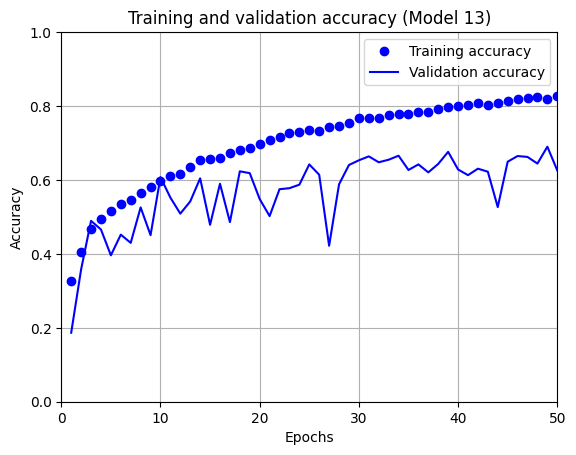

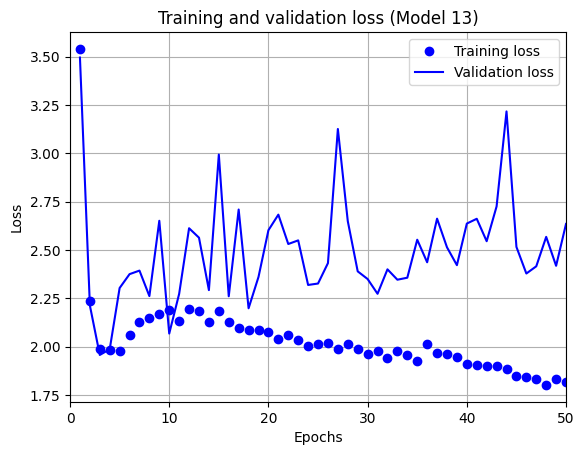

In [8]:
import matplotlib.pyplot as plt

acc13 = result13.history['accuracy']
val_acc13 = result13.history['val_accuracy']
loss13 = result13.history['loss']
val_loss13 = result13.history['val_loss']
epochs13 = range(1, len(acc13) + 1)

# Training and validation accuracy plot
plt.plot(epochs13, acc13, 'bo', label='Training accuracy')
plt.plot(epochs13, val_acc13, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 13)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

# Training and validation loss plot
plt.plot(epochs13, loss13, 'bo', label='Training loss')
plt.plot(epochs13, val_loss13, 'b', label='Validation loss')
plt.title('Training and validation loss (Model 13)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()